![](images/2021-05-20-used-cars.jpg){fig-align="center"}

<center><a href = "https://unsplash.com/photos/pdUVFX8WglY">Unsplash | Parker Gibbs</a></center>

# Overview

In 2016, Kaggle user `orgezleka` scraped data about used car advertisements on eBay Kleinanzeigen, which is the eBay Classifieds website of Germany. The full dataset is still available on [Used Cars Data (data.world 2016)](https://data.world/data-society/used-cars-data), with over 370,000 datapoints.

The project aims to answer the following questions:

- Which brands of the used cars are most expensive?
- Does a used car's age affect its price?
- Does a used car's mileage affect its price?
- Does the presence of unrepaired damage affect a car's price?

More importantly, this project aims to showcase basic data cleaning procedures. Thus, even columns beyond the scope of the research questions will be considered for cleaning. The assumption is that analysis will eventually be performed on all columns.


:::{.callout-note}

I wrote this notebook for the [Dataquest](https://www.dataquest.io/) course's [Guided Project: Exploring eBay Car Sales Data](https://app.dataquest.io/m/294/guided-project%3A-exploring-ebay-car-sales-data/9/next-steps). The general project flow came from Dataquest. However, all of the text and code here are written by me unless stated otherwise.

:::

# Package Installs

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Overview

Below is the information about each column in the dataset, taken from [Used Cars Data (data.world 2016)](https://data.world/data-society/used-cars-data).

- dateCrawled : when this ad was first crawled, all field-values are taken from this date
- name : "name" of the car
- seller : private or dealer
- offerType
- price : the price on the ad to sell the car
- abtest
- vehicleType
- yearOfRegistration : at which year the car was first registered
- gearbox
- powerPS : power of the car in PS
- model
- kilometer : how many kilometers the car has driven
- monthOfRegistration : at which month the car was first registered
- fuelType
- brand
- notRepairedDamage : if the car has a damage which is not repaired yet
- dateCreated : the date for which the ad at ebay was created
- nrOfPictures : number of pictures in the ad
- postalCode
- lastSeenOnline : when the crawler saw this ad last online

Let us view the first 5 rows of the dataset below.

In [5]:
autos = pd.read_csv("./private/2021-05-20-BDC-Files/autos.csv", encoding = "Windows-1252")

autos.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


We can get additional information about each column using `DataFrame.info()`.

In [6]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          371528 non-null  object
 1   name                 371528 non-null  object
 2   seller               371528 non-null  object
 3   offerType            371528 non-null  object
 4   price                371528 non-null  int64 
 5   abtest               371528 non-null  object
 6   vehicleType          333659 non-null  object
 7   yearOfRegistration   371528 non-null  int64 
 8   gearbox              351319 non-null  object
 9   powerPS              371528 non-null  int64 
 10  model                351044 non-null  object
 11  kilometer            371528 non-null  int64 
 12  monthOfRegistration  371528 non-null  int64 
 13  fuelType             338142 non-null  object
 14  brand                371528 non-null  object
 15  notRepairedDamage    299468 non-nu

The dataset has 371,528 rows and 20 columns. Each column contains one of two types of data:

- `int64`: 64-bit integers
- `object`: text strings

Also, some columns have a non-null count smaller than the number of entries. This means that there are missing values in these columns. The column `notRepairedDamage`has the most missing values.

# Data Cleaning

## Column Labels

As seen earlier, all of the column labels  are written in camel case. This means that the first letter of each word is capitalized, like `CamelCase.`

Column labels should ideally be written in `snake_case` so that these are easier to use. Thus, I will convert all column labels to snake case.

In [7]:
cols = list(autos.columns)

new_cols = []

for label in cols:
    # List of indices of the first letter of each word.
    cap_inds = [0] + [index for index, character in enumerate(label) if character.isupper()]
    
    # List of 2-tuples. Each tuple contains the start index of the current word
    # and the start index of the next word.
    zipped = list(zip(cap_inds, cap_inds[1:] + [None]))
    
    # Split the label into a list of words.
    # Make them lowercase and combine them with underscores.
    word_list = [label[i:j] for i, j in zipped]
    word_list = [word.lower() for word in word_list]
    new_label = "_".join(word_list)
    
    new_cols.append(new_label)
    
autos.columns = new_cols

autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   date_crawled           371528 non-null  object
 1   name                   371528 non-null  object
 2   seller                 371528 non-null  object
 3   offer_type             371528 non-null  object
 4   price                  371528 non-null  int64 
 5   abtest                 371528 non-null  object
 6   vehicle_type           333659 non-null  object
 7   year_of_registration   371528 non-null  int64 
 8   gearbox                351319 non-null  object
 9   power_p_s              371528 non-null  int64 
 10  model                  351044 non-null  object
 11  kilometer              371528 non-null  int64 
 12  month_of_registration  371528 non-null  int64 
 13  fuel_type              338142 non-null  object
 14  brand                  371528 non-null  object
 15  

Now, all of the column labels are in snake case. However, I will manually change a few of them to make them neater.

In [8]:
convert = {
    "power_p_s": "power_ps",
    "nr_of_pictures": "num_pictures",
    "year_of_registration": "year_reg",
    "kilometer": "mileage_km",
    "month_of_registration": "month_reg",
    "not_repaired_damage": "damage",
}

autos.columns = pd.Series(autos.columns).replace(convert)

autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   date_crawled  371528 non-null  object
 1   name          371528 non-null  object
 2   seller        371528 non-null  object
 3   offer_type    371528 non-null  object
 4   price         371528 non-null  int64 
 5   abtest        371528 non-null  object
 6   vehicle_type  333659 non-null  object
 7   year_reg      371528 non-null  int64 
 8   gearbox       351319 non-null  object
 9   power_ps      371528 non-null  int64 
 10  model         351044 non-null  object
 11  mileage_km    371528 non-null  int64 
 12  month_reg     371528 non-null  int64 
 13  fuel_type     338142 non-null  object
 14  brand         371528 non-null  object
 15  damage        299468 non-null  object
 16  date_created  371528 non-null  object
 17  num_pictures  371528 non-null  int64 
 18  postal_code   371528 non

All of the column labels are now easy to use.

## Uninformative Columns

Next, we will look for columns filled with mostly 1 value. The other values in them are underrepresented, so we wouldn't be able to compare groups reliably.

We can inspect the columns using `DataFrame.describe()`.

In [9]:
autos.describe(include = "all")
# Include all columns, including text.

,date_crawled,name,seller,offer_type,price,abtest,vehicle_type,year_reg,gearbox,power_ps,model,mileage_km,month_reg,fuel_type,brand,damage,date_created,num_pictures,postal_code,last_seen
count,371528,371528,371528,371528,3.715280e+05,371528,333659,371528.000000,351319,371528.000000,351044,371528.000000,371528.000000,338142,371528,299468,371528,371528.0,371528.00000,371528
unique,280500,233531,2,2,NaN,2,8,NaN,2,NaN,251,NaN,NaN,7,40,2,114,NaN,NaN,182806
top,2016-03-24 14:49:47,Ford_Fiesta,privat,Angebot,NaN,test,limousine,NaN,manuell,NaN,golf,NaN,NaN,benzin,volkswagen,nein,2016-04-03 00:00:00,NaN,NaN,2016-04-07 06:45:59
freq,7,657,371525,371516,NaN,192585,95894,NaN,274214,NaN,30070,NaN,NaN,223857,79640,263182,14450,NaN,NaN,17
mean,NaN,NaN,NaN,NaN,1.729514e+04,NaN,NaN,2004.577997,NaN,115.549477,NaN,125618.688228,5.734445,NaN,NaN,NaN,NaN,0.0,50820.66764,NaN
std,NaN,NaN,NaN,NaN,3.587954e+06,NaN,NaN,92.866598,NaN,192.139578,NaN,40112.337051,3.712412,NaN,NaN,NaN,NaN,0.0,25799.08247,NaN
min,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.00000,NaN
25%,NaN,NaN,NaN,NaN,1.150000e+03,NaN,NaN,1999.000000,NaN,70.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30459.00000,NaN
50%,NaN,NaN,NaN,NaN,2.950000e+03,NaN,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49610.00000,NaN
75%,NaN,NaN,NaN,NaN,7.200000e+03,NaN,NaN,2008.000000,NaN,150.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71546.00000,NaN


The `top` row gives the most frequent value in the column. The `freq` row tells exactly how often the `top` value occurs.

We can see that in the `seller` column, `"privat"` appears 371,525 times; this is close to the total number of entries. Also, in the `offer_type` column, `"Angebot"` appears 371,516 times.

Let us first check the unique values of the `seller` column.

In [10]:
autos["seller"].value_counts()

privat        371525
gewerblich         3
Name: seller, dtype: int64

In English, these mean "private" and "commercial." It is likely that private listings are put up by individuals, whereas commercial listings are put up by used car dealer companies. Most listings scraped were apparently private.

One idea is to compare private listing prices to commercial listing prices. However, there are only 3 commercial listings, so this comparison would be unreliable. Therefore, we can drop this column.

In [11]:
autos.drop(columns = "seller", inplace = True)

Secondly, let's check the unique values of the `offer_type` column.

In [12]:
autos["offer_type"].value_counts()

Angebot    371516
Gesuch         12
Name: offer_type, dtype: int64

In English, these mean "offer" and "request." This isn't very informative. It could have something to do with the system of sending Offers to buyers in eBay. In any case, it doesn't seem interesting to analyze, and there are only 12 request listings. Thus, we can also drop this column.

In [13]:
autos.drop(columns = "offer_type", inplace = True)

Next, the numerical `num_pictures` column has a minimum of 0 and a maximum of 0.

In [14]:
autos["num_pictures"].describe()

count    371528.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: num_pictures, dtype: float64

This means that none of the listings for used cars were found to have pictures. This data may be true or it may have come from an error, but either way, it is not useful. Thus, it will be dropped.

In [15]:
autos.drop(columns = "num_pictures", inplace = True)

## Outliers in Numerical Columns

Next, we inspect the ranges of numerical columns to see if there are any unusually high or low values.

In [16]:
autos.describe(include = np.number)

,price,year_reg,power_ps,mileage_km,month_reg,postal_code
count,3.715280e+05,371528.000000,371528.000000,371528.000000,371528.000000,371528.00000
mean,1.729514e+04,2004.577997,115.549477,125618.688228,5.734445,50820.66764
std,3.587954e+06,92.866598,192.139578,40112.337051,3.712412,25799.08247
min,0.000000e+00,1000.000000,0.000000,5000.000000,0.000000,1067.00000
25%,1.150000e+03,1999.000000,70.000000,125000.000000,3.000000,30459.00000
50%,2.950000e+03,2003.000000,105.000000,150000.000000,6.000000,49610.00000
75%,7.200000e+03,2008.000000,150.000000,150000.000000,9.000000,71546.00000
max,2.147484e+09,9999.000000,20000.000000,150000.000000,12.000000,99998.00000


The following unusual characteristics are noticeable:

- `price`: The minimum price is 0 (free) and the maximum price is larger than 2 billion.
- `year_reg`: The earliest year of registration is 1000, and the latest year is 9999.
- `power_ps`: The lowest power is 0 PS. The highest is 20,000 PS, which is much higher than the 75th percentile (only 150 PS).
- `month_reg`: The month numbers range from 0 to 12, not 1 to 12.

All of these columns shall be cleaned of inaccurate data.

### Price in Euros

It was seen that the minimum value for price data was 0, and the maximum is over 2,000,000,000. Since this data was scraped from the German eBay, we can assume that these prices are in euros.

Both the minimum and maximum values seem to be very unrealistic for the price of a used car, so we want to clean this data.

Let us create a frequency table of the prices. We will first sort it by price, ascending.

In [17]:
autos["price"].value_counts().sort_index()

0             10778
1              1189
2                12
3                 8
4                 1
              ...  
32545461          1
74185296          1
99000000          1
99999999         15
2147483647        1
Name: price, Length: 5597, dtype: int64

Two things are noticeable:

- There are over 10,000 instances of 0 euro prices.
- There are several extremely high outliers, not just the one above 2 billion.

Since it is unlikely that the cars are actually free, 0 may represent missing values. As for the high outliers, these may have resulted from inaccurate scraping.

The next question is, what is the most frequent price value? Is it 0?

In [18]:
autos["price"].value_counts().sort_values(ascending = False)

0        10778
500       5670
1500      5394
1000      4649
1200      4594
         ...  
2610         1
20620        1
16689        1
9964         1
10985        1
Name: price, Length: 5597, dtype: int64

Indeed, the most frequent price is 0, which makes it likely that it represents missing values. The next most frequent prices are 500, 1500, and 1000, most likely because these are easy for buyers to remember.

Now that we know about the low and high outliers, we can clean rows using the interquartile range or IQR. The IQR is bounded by the 25th and 75th percentiles. Reasonable lower and upper bounds can be approximated by multiplying the IQR length by 1.5 and:

- subtracting it from the 25th percentile
- adding it to the 75th percentile

*Reference: [Detection and Removal of Outliers in Python – An Easy to Understand Guide](https://www.askpython.com/python/examples/detection-removal-outliers-in-python)*

Below, I use this method to find a lower and upper bound, and I drop rows outside of them.

In [19]:
autos_desc = autos["price"].describe()

q25, q75 = autos_desc[["25%", "75%"]]

iqr = q75 - q25

lower_bound = q25 - 1.5 * iqr
upper_bound = q75 + 1.5 * iqr

autos = autos.loc[autos["price"].between(lower_bound, upper_bound)]

print("Lower bound:", lower_bound)
print("Upper bound:", upper_bound)
print("New shape:", autos.shape)

Lower bound: -7925.0
Upper bound: 16275.0
New shape: (343420, 17)


Now, there are 343,420 rows remaining in the dataset. This is still quite large; not too many datapoints were removed.

Let us view the new distribution of prices in a histogram.

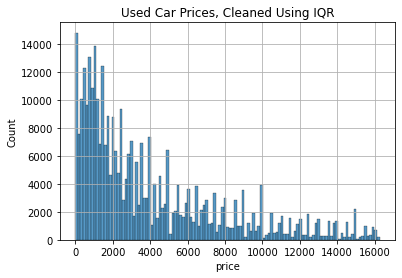

In [20]:
ax = sns.histplot(
    data = autos,
    x = "price",
)

ax.set_title("Used Car Prices, Cleaned Using IQR")
ax.grid(True)

plt.show()

Unfortunately, since the lower bound was negative, unrealistically low prices close to 0 were still accepted within the range.

Remember from earlier that the 2nd most frequent price value was found to be 500 euros. This makes it likely that these were correct prices, rather than incorrectly scraped values. Thus, let us keep all price values greater than or equal to 500.

In [21]:
autos = autos.loc[autos["price"] >= 500]

autos.shape

(307358, 17)

Now, 307,358 datapoints remain. Let us look at the final distribution of prices:

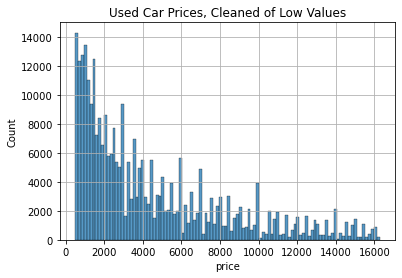

In [22]:
ax = sns.histplot(
    data = autos,
    x = "price",
)

ax.set_title("Used Car Prices, Cleaned of Low Values")
ax.grid(True)

plt.show()

The distribution is still right-skewed, but at least the price range in the dataset is more reasonable now.

### Metric Horsepower

We saw earlier that some power values were at 0 PS, and others were as high as 20,000 PS.

:::{.callout-note}

A measure of 1 PS (metric horsepower) is equivalent to 0.98 HP (horsepower). ([Deriquito 2020](https://www.autodeal.com.ph/articles/car-news-philippines/ps-vs-hp-understanding-spec-sheet))

:::

In [23]:
autos["power_ps"].describe()

count    307358.000000
mean        112.551842
std         191.557378
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power_ps, dtype: float64

Above are the new descriptive statistics for metric horsepower, after the transformations that we have done recently.

According to ["What is the Average Car Horsepower?" (2021)](https://www.autolist.com/guides/average-car-horsepower), cars usually have a horsepower of 100 HP to 400 HP, though some have less. Faster cars have 400 HP to 1,000 HP, and some supercars have over 1,000 HP. The equivalent values in PS would be slightly higher.

Considering that these are used cars, it is unlikely for them to be very fast much less to be supercars. Thus, we will keep cars with metric horsepowers between 50 and 450, in order to take as many of the realistic values as possible.

In [24]:
autos = autos.loc[autos["power_ps"].between(50, 450)]

autos["power_ps"].describe()

count    274514.000000
mean        121.166931
std          50.535320
min          50.000000
25%          82.000000
50%         114.000000
75%         150.000000
max         450.000000
Name: power_ps, dtype: float64

Let us view the distribution of power values in a histogram.

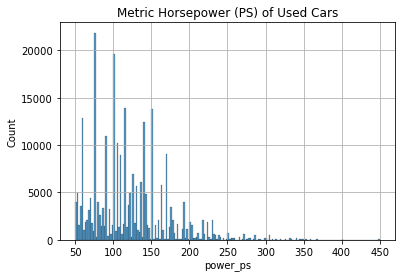

In [25]:
ax = sns.histplot(
    data = autos,
    x = "power_ps",
)

ax.set_title("Metric Horsepower (PS) of Used Cars")
ax.grid(True)

plt.show()

Like the price data, the power data are right-skewed. Lower values are more frequent. Still, we managed to capture most (274,514) of the datapoints using this range.

### Year of Registration

Earlier, we noticed that the years of registration ranged from 1000 to 9999.

In [26]:
autos["year_reg"].describe()

count    274514.000000
mean       2003.658039
std          29.529992
min        1000.000000
25%        1999.000000
50%        2004.000000
75%        2007.000000
max        9999.000000
Name: year_reg, dtype: float64

Logically, the years of registration should only range from when automobiles were first mass-produced, in the 1800s or 1900s ([Encyclopedia Britannica](https://www.britannica.com/technology/automobile/History-of-the-automobile)), to the year when the ads were last seen by the web crawler.

We can know when the ads were last seen using the `last_seen` column of the dataset. The dates are shown as strings with years first, so we can sort them in descending order to find the most recent date.

In [27]:
autos["last_seen"].sort_values(ascending = False)

343211    2016-04-07 14:58:51
5069      2016-04-07 14:58:50
72231     2016-04-07 14:58:50
62402     2016-04-07 14:58:50
122068    2016-04-07 14:58:50
                 ...         
244077    2016-03-05 14:35:28
177326    2016-03-05 14:25:59
136842    2016-03-05 14:15:39
275196    2016-03-05 14:15:16
311225    2016-03-05 14:15:08
Name: last_seen, Length: 274514, dtype: object

It looks like all of the ads were last seen in 2016, so the cars could not have been registered beyond that year.

Therefore, a reasonable range of years would be from 1900 to 2016. Let us keep all rows within this range.

In [28]:
autos = autos.loc[autos["year_reg"].between(1900, 2016)]

autos["year_reg"].describe()

count    264977.000000
mean       2002.977877
std           6.097207
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: year_reg, dtype: float64

Now, the years of registration range from 1910 to 2016. There are also 264,977 datapoints remaining.

### Months of Registration

Lastly, we noticed that the months of registration included integers from 0 to 12, not 1 to 12. Let us make a discrete histogram in order to understand the distribution.

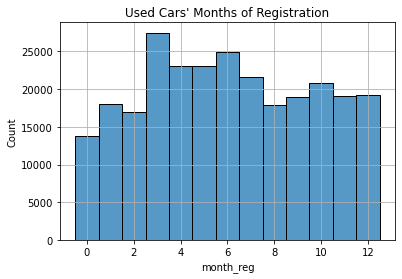

In [29]:
ax = sns.histplot(
    data = autos,
    x = "month_reg",
    discrete = True,
)

ax.set_title("Used Cars' Months of Registration")
ax.grid(True)

plt.show()

The graph above shows that 0 is the least frequent value, appearing under 15,000 times. It seems very likely that it is a placeholder for unknown months. Therefore, we can remove rows with month 0.

In [30]:
autos = autos.loc[autos["month_reg"] >= 1]

autos["month_reg"].describe()

count    251198.000000
mean          6.396237
std           3.346424
min           1.000000
25%           4.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: month_reg, dtype: float64

##  Missing Values

Now, we shall deal with the null values in the dataset. First, how many null values are there per column?

In [31]:
autos.isnull().sum()

date_crawled        0
name                0
price               0
abtest              0
vehicle_type     5871
year_reg            0
gearbox          3103
power_ps            0
model            7422
mileage_km          0
month_reg           0
fuel_type        9057
brand               0
damage          28718
date_created        0
postal_code         0
last_seen           0
dtype: int64

There are thousands of missing values for the vehicle type, gearbox, model, fuel type, and presence of damage. None of these can be easily determined from other columns.

If we were to remove all rows with these missing values, we would be left with:

In [32]:
autos.dropna().shape

(208538, 17)

We would have 208,538 rows left. This is just over half of the original number of datapoints we started with, 371,528.

This project is meant to showcase data cleaning, and we are assuming that all of the columns in the dataset will be used for analysis. Thus, we will have to delete all rows with missing values.

In [33]:
autos.dropna(inplace = True)

Below are the final descriptive statistics for the dataset after all of the cleaning.

In [34]:
autos.describe(include = "all")

,date_crawled,name,price,abtest,vehicle_type,year_reg,gearbox,power_ps,model,mileage_km,month_reg,fuel_type,brand,damage,date_created,postal_code,last_seen
count,208538,208538,208538.000000,208538,208538,208538.000000,208538,208538.000000,208538,208538.000000,208538.000000,208538,208538,208538,208538,208538.000000,208538
unique,177458,114617,NaN,2,8,NaN,2,NaN,248,NaN,NaN,7,39,2,98,NaN,116677
top,2016-04-02 22:54:55,BMW_318i,NaN,test,limousine,NaN,manuell,NaN,golf,NaN,NaN,benzin,volkswagen,nein,2016-04-03 00:00:00,NaN,2016-04-07 09:45:41
freq,5,616,NaN,108258,62894,NaN,166213,NaN,17505,NaN,NaN,136145,44157,189720,8271,NaN,14
mean,NaN,NaN,4984.662522,NaN,NaN,2003.205953,NaN,122.635031,NaN,128250.990227,6.381225,NaN,NaN,NaN,NaN,51907.756020,NaN
std,NaN,NaN,3990.028529,NaN,NaN,5.696916,NaN,50.515054,NaN,35781.848172,3.350349,NaN,NaN,NaN,NaN,25766.228717,NaN
min,NaN,NaN,500.000000,NaN,NaN,1937.000000,NaN,50.000000,NaN,5000.000000,1.000000,NaN,NaN,NaN,NaN,1067.000000,NaN
25%,NaN,NaN,1749.000000,NaN,NaN,2000.000000,NaN,85.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,31319.000000,NaN
50%,NaN,NaN,3750.000000,NaN,NaN,2004.000000,NaN,116.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,51371.000000,NaN
75%,NaN,NaN,7300.000000,NaN,NaN,2007.000000,NaN,150.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,72649.000000,NaN


# Data Transformation

## Strings to Datetime Objects

As we saw earlier, the `date_crawled`, `date_created`, and `last_seen` columns contain dates and times in string format. It would be better to store these as datetime objects so that each part (year, month, etc.) can be accessed in analysis.

For this section, I used ["Convert the column type from string to datetime format in Pandas dataframe" (2020)](https://www.geeksforgeeks.org/convert-the-column-type-from-string-to-datetime-format-in-pandas-dataframe/) as a reference.

First, though, we have to make a format string so that the numbers can be parsed properly.

In [35]:
autos[["date_crawled", "date_created", "last_seen"]].head()

,date_crawled,date_created,last_seen
3,2016-03-17 16:54:04,2016-03-17 00:00:00,2016-03-17 17:40:17
4,2016-03-31 17:25:20,2016-03-31 00:00:00,2016-04-06 10:17:21
5,2016-04-04 17:36:23,2016-04-04 00:00:00,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2016-04-01 00:00:00,2016-04-05 18:18:39
10,2016-03-26 19:54:18,2016-03-26 00:00:00,2016-04-06 10:45:34


All 3 columns seem to follow the same format:

{4 digit year}-{2 digit month}-{2 digit day} {24-hour time hour}:{minute}:{second}

The equivalent format string is below.

In [36]:
format_str = "%Y-%m-%d %H:%M:%S"

We can use this string to parse the dates. This can be done quickly by using the `pd.to_datetime()` vectorized function, instead of using a for-loop with the `datetime` module.

In [37]:
autos["date_crawled"] = pd.to_datetime(
    autos["date_crawled"],
    format = format_str,
)

autos["date_crawled"]

3        2016-03-17 16:54:04
4        2016-03-31 17:25:20
5        2016-04-04 17:36:23
6        2016-04-01 20:48:51
10       2016-03-26 19:54:18
                 ...        
371516   2016-04-04 09:57:12
371517   2016-03-28 13:48:07
371520   2016-03-19 19:53:49
371524   2016-03-05 19:56:21
371525   2016-03-19 18:57:12
Name: date_crawled, Length: 208538, dtype: datetime64[ns]

We can see that the values look similar to how they looked before, but the dtype is now `datetime64[ns]`.

For example, we can now access the month and day from the datetime objects.

In [38]:
autos["date_crawled"].iloc[0].month

3

In [39]:
autos["date_crawled"].iloc[0].day

17

We can see that the date in the first row has a month of 3 (March) and a day of 17.

Let us do the same for the other 2 date columns.

In [40]:
autos["date_created"] = pd.to_datetime(
    autos["date_created"],
    format = format_str,
)

autos["last_seen"] = pd.to_datetime(
    autos["last_seen"],
    format = format_str,
)

autos[["date_crawled", "date_created", "last_seen"]].describe(
    datetime_is_numeric = True,
)

,date_crawled,date_created,last_seen
count,208538,208538,208538
mean,2016-03-21 13:39:21.839721984,2016-03-20 19:44:12.604321536,2016-03-30 09:43:36.598633984
min,2016-03-05 14:06:23,2015-08-07 00:00:00,2016-03-05 14:15:16
25%,2016-03-13 11:06:28,2016-03-13 00:00:00,2016-03-23 20:52:41.500000
50%,2016-03-21 18:46:44.500000,2016-03-21 00:00:00,2016-04-04 14:39:49.500000
75%,2016-03-29 15:36:22.500000,2016-03-29 00:00:00,2016-04-06 11:45:07
max,2016-04-07 14:36:58,2016-04-07 00:00:00,2016-04-07 14:58:51


We can see that since the 3 columns are in datetime format, they are now treated as numerical values. They have a mean and a list of percentiles.

Data transformation is done, so we can move on to data analysis.

# Data Analysis

Statistical analyses with hypothesis testing are outside of the scope of this project, since it is centered on data cleaning. Thus, I will perform some simple aggregates and visualize them in graphs.

## Most Expensive Car Brands

Below, a bar graph shows each car brand and the median price. The mean is not used because we know that the price data are right-skewed, not normal.

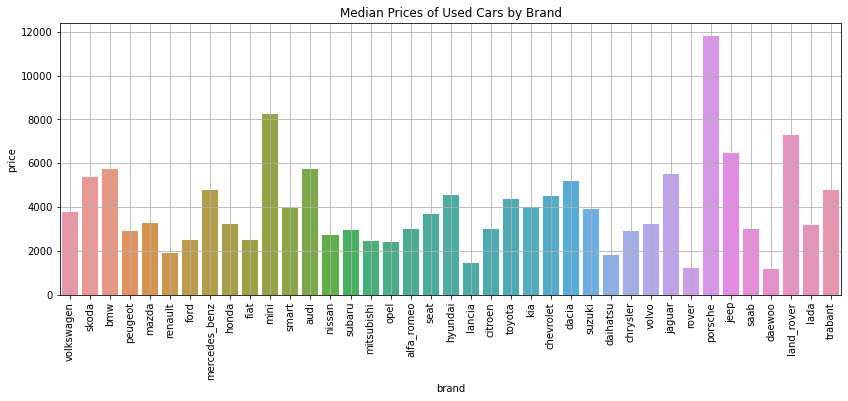

In [41]:
plt.figure(figsize = (14, 5))

ax = sns.barplot(
    data = autos,
    x = "brand",
    y = "price",
    estimator = np.median,
    ci = None,
)

plt.title("Median Prices of Used Cars by Brand")
plt.grid(True)
plt.xticks(rotation = 90)

plt.show()

The graph shows that Porsche has the highest median price of used cars, at almost 12,000 euros. This is followed by Mini, Land Rover, and Jeep.

## Used Car Prices by Age

The line plot below shows the relationship between a car's year of registration (later -> newer) and the median price.

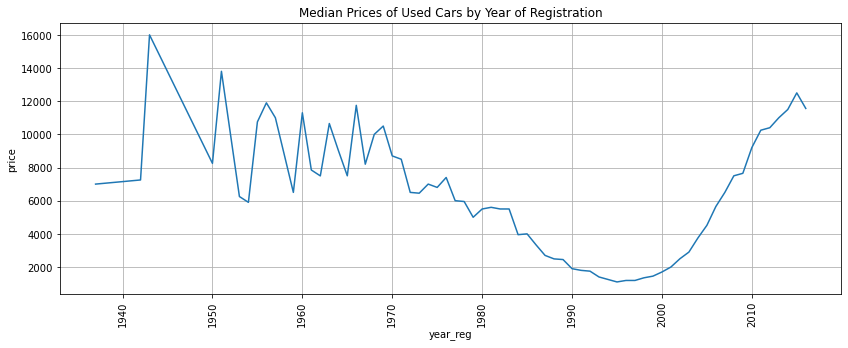

In [42]:
plt.figure(figsize = (14, 5))

ax = sns.lineplot(
    data = autos,
    x = "year_reg",
    y = "price",
    estimator = np.median,
    ci = None,
)

plt.title("Median Prices of Used Cars by Year of Registration")
plt.grid(True)
plt.xticks(rotation = 90)

plt.show()

The line plot shows that used car prices are lowest when the year of registration is in the mid-1990s.

To the right of the minimum, as the year of registration gets later, the median price steadily becomes higher. This makes sense because newer cars would have a higher value, even if they're used.

On the other hand, to the left of the minimum, the median price increases (albeit erratically) as the year of registration gets earlier. This suggests that very old cars are considered to be valuable because they are rare. It is likely that the avid car collectors are the ones who pay such high prices for these cars.

## Used Car Prices by Mileage

The line plot below shows the relationship between used cars' mileage in kilometers and the median price.

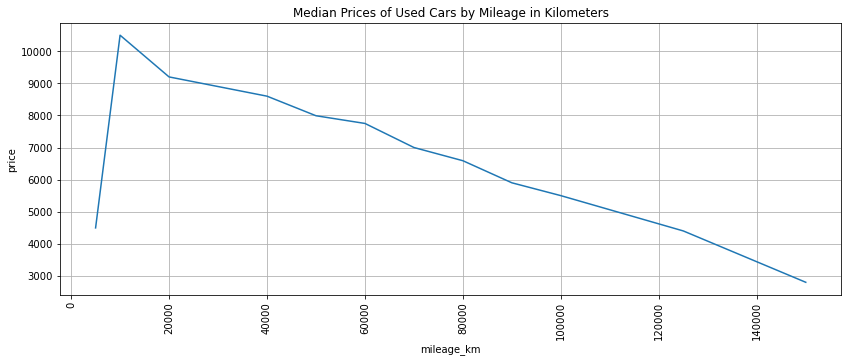

In [43]:
plt.figure(figsize = (14, 5))

ax = sns.lineplot(
    data = autos,
    x = "mileage_km",
    y = "price",
    estimator = np.median,
    ci = None,
)

plt.title("Median Prices of Used Cars by Mileage in Kilometers")
plt.grid(True)
plt.xticks(rotation = 90)

plt.show()

As expected, price decreases as mileage increases. What is unexpected is that there is a sharp increase in price from around 500 km to 1000 km. This was likely caused by an outlier datapoint which had a low mileage and a low price.

## Effect of Presence of Damage on Used Car Price

Lastly, we will analyze the effect of the presence of unrepaired damage on the median price of used cars.

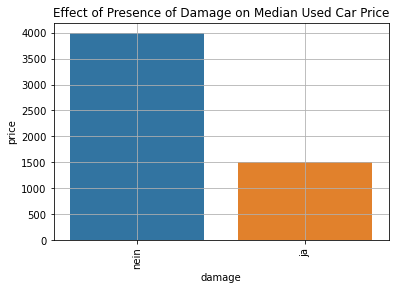

In [44]:
ax = sns.barplot(
    data = autos,
    x = "damage",
    y = "price",
    estimator = np.median,
    ci = None,
)

plt.title("Effect of Presence of Damage on Median Used Car Price")
plt.grid(True)
plt.xticks(rotation = 90)

plt.show()

It can be seen that the median price of used cars without damage is 4000 euros. The median price is 1500 euros for those with unrepaired damage.

Therefore, cars with damage generally have lower prices. This makes sense because if the buyer plans to drive the car, they must shoulder the expense of repairing it.

# Conclusion

In this project, we did cleaning, transformation, and simple analyses on data about used cars. Below are the insights we gained with regards to each research question. Note that prices were aggregated using the median, not the mean.

- **Which brands of the used cars are most expensive?**

The top 4 most expensive brands of used cars are Porsche, Mini, Land Rover, and Jeep (descending order).

<br/>

- **Does a used car's age affect its price?**

Yes. Cars registered in the mid-1990s have the lowest prices, with a median of 1000 euros.

As cars get newer from that point, their median price increases. As cars get older from the same point, their median price also increases. Very old cars are rare and therefore valuable to collectors.

<br/>

- **Does a used car's mileage affect its price?**

Yes, as mileage increases, price decreases.

<br/>

- **Does the presence of unrepaired damage affect a car's price?**

Yes, the median price of damaged used cars is much lower than that of cars without damage.

<br/>

---

Thanks for reading!